In [1]:
import torch
import torch.nn as nn
from torch import optim
from einops import rearrange

import os
import time
import glob
import datetime
from sklearn import neighbors
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix

torch.cuda.empty_cache()
torch.manual_seed(0)

In [2]:
#@title ViT Implementation 🔥
import math
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv =  nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=2)
        
        
    def forward(self, x):
        return self.maxpool(self.act((self.bn(self.conv(x)))))

class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        # self.num_patches = (self.image_size // self.patch_size) ** 3
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.conv_1 = ConvBlock(self.num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = ConvBlock(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv_4 = ConvBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv_5 = ConvBlock(256, 512, kernel_size=3, stride=1, padding=1)
        self.num_patches = 512
        #self.projection = nn.Conv3d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_depth, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        #x = self.projection(x)
        x = rearrange(x, 'b c d w h -> b c (d w h)')
        
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.attention_pool = nn.Linear(self.hidden_size, 1)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        cls_logits, activation_logits = encoder_output[:, 0, :], encoder_output[:, 1:, :]
        activation_logits = torch.matmul(nn.functional.softmax(self.attention_pool(activation_logits), dim=1).transpose(-1, -2), activation_logits).squeeze(-2)
        logits = torch.cat((cls_logits, activation_logits), dim=1)
        logits = self.classifier(activation_logits)
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [3]:
config = {
    'batch_size' : 3,
    'image_size' : 192,
    'patch_size' : 6,
    "hidden_size": 216,
    "num_hidden_layers": 3,
    "num_attention_heads": 8,
    "intermediate_size": 3 * 216, # 3 * hidden_size
    "hidden_dropout_prob": 0.25,
    "attention_probs_dropout_prob": 0.25,
    "initializer_range": 0.02,
    "num_classes": 3, # num_classes
    "num_channels": 1,
    "qkv_bias": True,
    "use_faster_attention": True,
    'lr' : 8e-5,
    'save_model_every' : 0,
    'exp_name' : '3D ViT Final CCT',
    'model_name' : 'CCT',
    'base_dir' : 'experiments',
    'epochs' : 100
}

In [4]:
import wandb
wandb.login()

wandb.init(
    # Set the project where this run will be logged
    project="Alzheimer Detection 3D CViT", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"Final 3D ViT with Convolution{datetime.datetime.now()}", 
    # Track hyperparameters and run metadata
    config=config
)

wandb: Currently logged in as: arindammajee (tcg_). Use `wandb login --relogin` to force relogin


In [5]:
#@title Prepare Data 📊
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchio as tio

class FolderDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.image_paths = glob.glob(f'{self.folder}/*/*.pt')
        self.labels = {
            'CN' : 0,
            'MCI' : 1,
            'AD' : 2
        }
        self.transform = False #tio.transforms.Compose(
            #[tio.transforms.RandomAffine(degrees=5)
            #tio.transforms.RandomBiasField()])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __label_dist__(self):
        cn,mci, ad = 0, 0, 0
        for path in self.image_paths:
            if self.__label_extract__(path) == 0:
                cn += 1
            elif self.__label_extract__(path) == 1:
                mci += 1
            elif self.__label_extract__(path) == 2:
                ad += 1
        
        return {'CN': cn, 'MCI': mci, 'AD': ad}
    
    def __label_extract__(self, path):
        if 'CN' in path:
            return 0
        elif 'MCI' in path:
            return 1
        elif 'AD' in path:
            return 2
        
    def __getitem__(self, idx):
        tensor, label = torch.load(self.image_paths[idx]), self.__label_extract__(self.image_paths[idx])
        if self.transform:
            tensor = self.transform(tensor)
        
        return tensor, label
    
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_dataset = FolderDataset(folder='/home/admin1/Arindam/Alzheimer/ViT/data/3D (part II)/Train')
    val_dataset = FolderDataset(folder='/home/admin1/Arindam/Alzheimer/ViT/data/3D (part II)/Val')
    test_dataset = FolderDataset(folder='/home/admin1/Arindam/Alzheimer/ViT/data/3D (part II)/Test')

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    classes = ('CN', 'MCI', 'AD')
    class_dist = {
        'Train': train_dataset.__label_dist__(),
        'Val': val_dataset.__label_dist__(),
        'Test': test_dataset.__label_dist__()
    }
    
    return train_loader, valid_loader, test_loader, class_dist

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#@title Utils 🛠️
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, val_losses, train_acces, val_acces, train_logs, base_dir=config['base_dir']):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acces': train_acces,
            'val_acces': val_acces
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, 'final', base_dir=base_dir)
    
    # Save the logs
    logfile = os.path.join(outdir, 'logs.txt')
    with open(logfile, 'w') as f:
        TEXT = ""
        for logs in train_logs:
            TEXT += f"{logs}\n"
        f.write(TEXT)


def save_checkpoint(experiment_name, model, epoch, base_dir=config['base_dir']):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir=config['base_dir']):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    val_losses = data['val_losses']
    train_acces = data['train_acces']
    val_acces = data['val_acces']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, val_losses, train_acces,val_acces



def visualize_images(dataset):
    classes = ('CN', 'MCI', 'AD')

    # Pick 4 samples randomly
    indices = torch.randperm(len(dataset))[:4]
    images = [np.asarray(dataset[i][0]) for i in indices]
    labels = [dataset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        img = np.squeeze(images[i])
        img_1 = img[img.shape[0]//2, :, :]
        ax = fig.add_subplot(4, 3, 3*i+1, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_1), cmap='gray')
        ax.set_title(f"{classes[labels[i]]} (sagital)")
        
        img_2 = img[:, img.shape[1]//2, :]
        ax = fig.add_subplot(4, 3, 3*i+2, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_2), cmap='gray')
        ax.set_title(f"{classes[labels[i]]} (coronal)")
        
        img_3 = img[:, :, img.shape[2]//2]
        ax = fig.add_subplot(4, 3, 3*i+3, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_3), cmap='gray')
        ax.set_title(f"{classes[labels[i]]} (axial)")

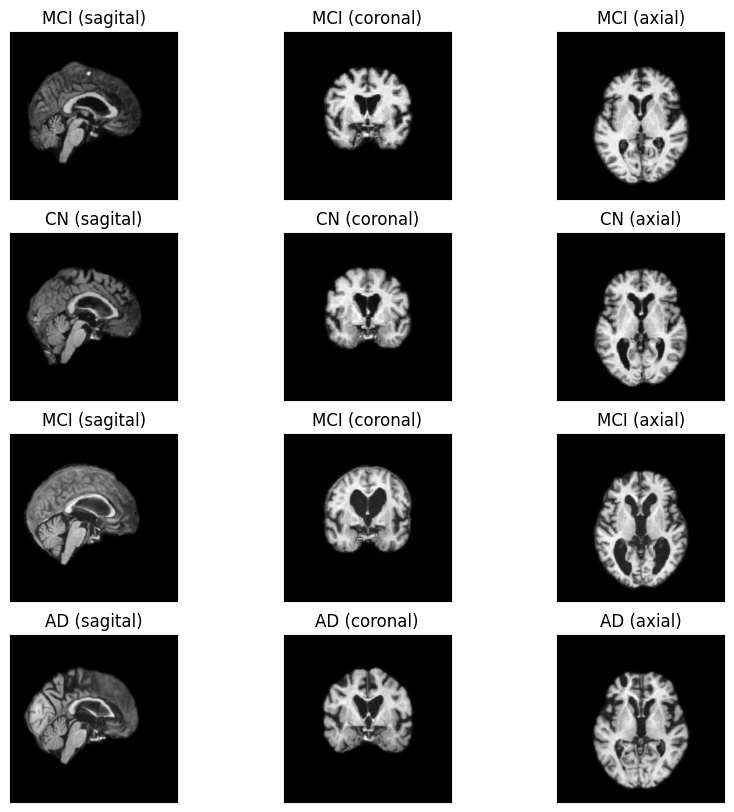

In [7]:
train_dataset = FolderDataset(folder='/home/admin1/Arindam/Alzheimer/ViT/data/3D (part II)/Train')
visualize_images(train_dataset)

In [8]:
class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, valloader, epochs, scheduler, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, val_losses, train_acces, val_acces, train_logs = [], [], [], [], []
        # Keep track of best model
        best_train_loss, best_val_loss = 1.0, 1.0
        # Train the model
        start_time = time.time()
        for i in range(epochs):
            train_loss, train_acc = self.train_epoch(trainloader)
            val_loss, val_acc = self.evaluate(valloader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_acces.append(train_acc)
            val_acces.append(val_acc)
            total_time = time.time() - start_time
            text = f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {total_time/60:.1f}min ({total_time/(60*(i+1)):.1f} min/epoch)"
            print(text)
            train_logs.append(text)
            if train_loss < best_train_loss and val_loss < best_val_loss:
                best_train_loss, best_val_loss = train_loss, val_loss
                text = f"\tSave best checkpoint at epoch {i+1}"
                print(text)
                save_checkpoint(self.exp_name, self.model, 'best')
                train_logs.append(text)
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
            wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}, commit=True)
            scheduler.step()
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, val_losses, train_acces, val_acces, train_logs)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss, total_correct = 0, 0

        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            logits = self.model(images)[0]
            loss = self.loss_fn(logits, nn.functional.one_hot(labels, num_classes=3).type(torch.FloatTensor).cuda())
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
            
            # Calculate the accuracy
            predictions = torch.argmax(logits, dim=1)
            total_correct += torch.sum(predictions == labels).item()

        return total_loss / len(trainloader.dataset), total_correct/len(trainloader.dataset)

    
    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits = self.model(images)[0]

                # Calculate the loss
                loss = self.loss_fn(logits, nn.functional.one_hot(labels, num_classes=3).type(torch.FloatTensor).cuda())
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return avg_loss, accuracy

    
# Get parameters for each layer of the model in a tabular format
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [9]:
train_loader, valid_loader, test_loader, class_dist = prepare_data()

print(f"Total number of images in train, val and test set are, {len(train_loader.dataset)}, {len(valid_loader.dataset)}, {len(test_loader.dataset)}")

assert len(train_loader.dataset)==1526
assert len(valid_loader.dataset)==326
assert len(test_loader.dataset)==330

print(f"\t\tCN\tMCI\tAD")
for key in class_dist.keys():
    print(f"{key}\t: \t{class_dist[key]['CN']}\t{class_dist[key]['MCI']}\t{class_dist[key]['AD']}")
# Check a sample batch size
idx =0
for data in train_loader:
    images, labels = data
    print(f"\nShape of images and labels of a signle batch is {images.shape} and {labels.shape} respectively.")
    break

Total number of images in train, val and test set are, 1526, 326, 330
		CN	MCI	AD
Train	: 	523	686	317
Val	: 	112	147	67
Test	: 	113	148	69

Shape of images and labels of a signle batch is torch.Size([3, 1, 192, 192, 192]) and torch.Size([3]) respectively.


In [10]:
# Load the dataset
# Create the model, optimizer, loss function and trainer
model = ViTForClassfication(config)
print(model)
count_parameters(model)
# Get number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}, Trainable Parameters {total_trainable_params}\nTotal parameters: {total_params/1000000}M, Trainable Parameters {total_trainable_params/1000000}M")

ViTForClassfication(
  (embedding): Embeddings(
    (patch_embeddings): PatchEmbeddings(
      (conv_1): ConvBlock(
        (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv_2): ConvBlock(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv_3): ConvBlock(
        (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
    

In [11]:
# Training parameters
save_model_every_n_epochs = config['save_model_every']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40, 50], gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

In [12]:
trainer = Trainer(model, optimizer, loss_fn, config['model_name'], device=device)
trainer.train(train_loader, valid_loader, config['epochs'], scheduler, save_model_every_n_epochs=save_model_every_n_epochs)
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"\n\nTest Loss: {test_loss} and Test Accuracy: {test_acc}")
wandb.log({"Test Loss": test_loss, "Test Accuracy": test_acc})

Epoch: 1, Train loss: 1.0577, Train Acc: 0.4364, Val loss: 1.0482, Val Acc: 0.4509, Time: 2.3min (2.3 min/epoch)
Epoch: 2, Train loss: 0.9766, Train Acc: 0.4764, Val loss: 0.9235, Val Acc: 0.5399, Time: 4.7min (2.3 min/epoch)
	Save best checkpoint at epoch 2
Epoch: 3, Train loss: 0.8348, Train Acc: 0.5682, Val loss: 0.7417, Val Acc: 0.6196, Time: 7.0min (2.3 min/epoch)
	Save best checkpoint at epoch 3
Epoch: 4, Train loss: 0.6672, Train Acc: 0.7031, Val loss: 0.9095, Val Acc: 0.6319, Time: 9.3min (2.3 min/epoch)
Epoch: 5, Train loss: 0.4677, Train Acc: 0.8041, Val loss: 0.4945, Val Acc: 0.7975, Time: 11.7min (2.3 min/epoch)
	Save best checkpoint at epoch 5
Epoch: 6, Train loss: 0.3008, Train Acc: 0.8755, Val loss: 0.9239, Val Acc: 0.7423, Time: 14.0min (2.3 min/epoch)
Epoch: 7, Train loss: 0.2339, Train Acc: 0.9161, Val loss: 0.6559, Val Acc: 0.8282, Time: 16.3min (2.3 min/epoch)
Epoch: 8, Train loss: 0.1447, Train Acc: 0.9430, Val loss: 0.7055, Val Acc: 0.8282, Time: 18.6min (2.3 min/

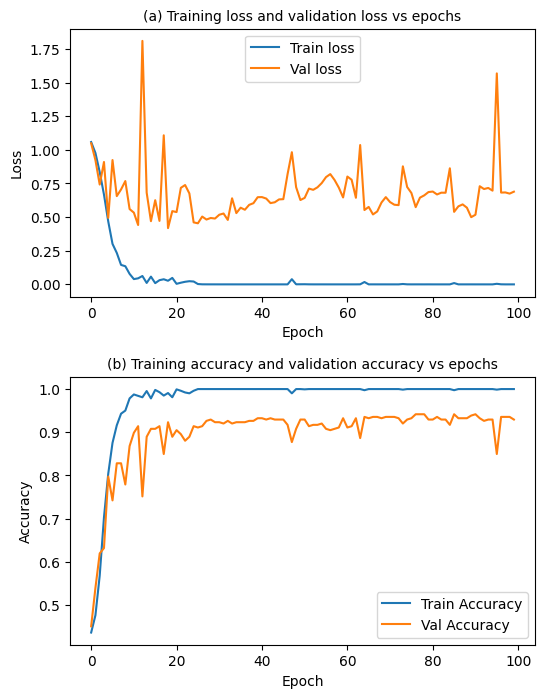

In [15]:
#@title Plot training Results
config, model, train_losses, val_losses, train_acces,val_acces = load_experiment(f"../{config['base_dir']}/{config['model_name']}/")

#import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(train_losses, label="Train loss")
ax1.plot(val_losses, label="Val loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("(a) Training loss and validation loss vs epochs", fontsize='10')

ax2.plot(train_acces, label="Train Accuracy")
ax2.plot(val_acces, label="Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("(b) Training accuracy and validation accuracy vs epochs", fontsize='10')
plt.subplots_adjust(hspace=0.3)
plt.savefig(f"{config['base_dir']}/{config['model_name']}/metrics.png", dpi=600, bbox_inches='tight')
plt.show()

In [16]:
trainer = Trainer(model, optimizer, loss_fn, config['model_name'], device=device)
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"\n\nTest Loss: {test_loss} and Test Accuracy: {test_acc}")



Test Loss: 0.6672136650727261 and Test Accuracy: 0.9272727272727272


In [17]:
# Load the best model
final_model = ViTForClassfication(config)
final_model.load_state_dict(torch.load(f"/home/admin1/Arindam/Alzheimer/ViT/{config['base_dir']}/{config['model_name']}/model_best.pt"))
   
trainer = Trainer(final_model, optimizer, loss_fn, config['exp_name'], device=device)
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"\n\nTest Loss: {test_loss} and Test Accuracy: {test_acc}")



Test Loss: 0.39465668722076025 and Test Accuracy: 0.9030303030303031
